In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             roc_curve)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (DataLoader, TensorDataset,
                              WeightedRandomSampler)
import matplotlib.pyplot as plt
from torchvision.transforms import Compose
from tqdm import tqdm

# 固定随机种子
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------------------------
# 时间序列增强模块
# --------------------------
class TemporalAugmentation:
    """时间序列数据增强"""
    def __init__(self, sigma=0.1, p=0.5):
        self.sigma = sigma  # 噪声强度
        self.p = p  # 应用概率

    def __call__(self, x):
        if np.random.rand() < self.p:
            noise = torch.randn_like(x) * self.sigma
            return x + noise
        return x

# --------------------------
# 残差块模块（改进版）
# --------------------------
class ResidualBlock(nn.Module):
    """带通道注意力机制的残差块"""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # 通道注意力机制
        self.ca = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(out_channels, out_channels // 8, 1),
            nn.ReLU(),
            nn.Conv1d(out_channels // 8, out_channels, 1),
            nn.Sigmoid()
        )

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out) 
        out = self.conv2(out)
        out = self.bn2(out)


        # 通道注意力
        ca_weight = self.ca(out)
        out = out * ca_weight

        out += identity
        out = self.relu(out)
        return out

# --------------------------
# 改进的CNN模型
# --------------------------
class DynamicCNN(nn.Module):
    """带数据增强和时间感知的CNN"""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim

        # 数据增强层
        self.augment = Compose([TemporalAugmentation(sigma=0.05, p=0.3)])

        # 特征预处理
        self.preprocess = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),
            nn.GELU()
        )

        # 残差卷积模块
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            ResidualBlock(16, 16),
            nn.MaxPool1d(2),
            ResidualBlock(16, 32),
            nn.AdaptiveAvgPool1d(8)
        )

        # 动态计算全连接输入维度
        with torch.no_grad():
            dummy = torch.randn(2, input_dim)
            dummy = self.preprocess(dummy).unsqueeze(1)
            dummy = self.conv_layers(dummy)
            self.fc_input = dummy.view(dummy.size(0), -1).shape[1]

        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input, 64),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x, augment=True):
        if self.training and augment:
            x = self.augment(x)
        x = self.preprocess(x).unsqueeze(1)
        features = self.conv_layers(x).view(x.size(0), -1)
        return self.classifier(features).squeeze(1)

# --------------------------
# 注意力融合模块
# --------------------------
class AttentionFusion(nn.Module):
    """基于注意力的模型融合"""
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.attention = nn.Sequential(
            nn.Linear(2, 8),
            nn.Tanh(),
            nn.Linear(8, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x1, x2):
        with torch.no_grad():
            logitA = self.modelA(x1)
            logitB = self.modelB(x2)
        concat_logits = torch.stack([logitA, logitB], dim=1)
        weights = self.attention(concat_logits)
        probA = torch.sigmoid(logitA)
        probB = torch.sigmoid(logitB)
        return (weights[:, 0] * probA) + (weights[:, 1] * probB)

# --------------------------
# 模型解释模块
# --------------------------
def feature_importance(model, X, feature_names, n_samples=1000):
    model.eval()
    baseline = torch.mean(X, dim=0, keepdim=True)
    delta_list = []
    
    # 确保特征数量与特征名称数量一致
    if X.shape[1] != len(feature_names):
        print(f"警告：特征数量 ({X.shape[1]}) 与特征名称数量 ({len(feature_names)}) 不匹配")
        print("可能原因：数据预处理时某些列未被正确移除或加载")
        return
    
    with torch.no_grad():
        for i in tqdm(range(X.shape[1])):
            perturbed = X.clone()
            perturbed[:, i] = baseline[0, i]
            orig_output = torch.sigmoid(model(X))
            perturbed_output = torch.sigmoid(model(perturbed))
            delta = torch.mean(torch.abs(orig_output - perturbed_output)).item()
            delta_list.append(delta)

    # 动态确定显示数量
    display_num = min(20, len(delta_list))  # 取特征数量和前20中的较小值
    indices = np.argsort(delta_list)[::-1][:display_num]  # 只取实际存在的索引
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(display_num), [delta_list[i] for i in indices][::-1])
    plt.yticks(range(display_num), [feature_names[i] for i in indices][::-1])
    plt.xlabel('Importance Score')
    plt.title(f'Top {display_num} Important Features')
    plt.tight_layout()
    plt.show()

# --------------------------
# 训练评估模块（优化版）
# --------------------------
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion,
                       scheduler=None, epochs=30, save_path='best_model.pth'):
    history = {'train_loss': [], 'val_auc': [], 'val_f1': [],
               'val_accuracy': [], 'val_precision': []}
    best_auc = 0
    early_stop = EarlyStopper(patience=10)

    for epoch in range(epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # 验证阶段
        model.eval()
        y_true, y_probs = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                outputs = model(X)
                y_true.extend(y.cpu().numpy())
                y_probs.extend(torch.sigmoid(outputs).cpu().numpy())

        # 计算指标
        auc = roc_auc_score(y_true, y_probs)
        preds = np.round(y_probs)
        f1 = f1_score(y_true, preds)
        accuracy = accuracy_score(y_true, preds)
        precision = precision_score(y_true, preds)

        history['val_auc'].append(auc)
        history['val_f1'].append(f1)
        history['val_accuracy'].append(accuracy)
        history['val_precision'].append(precision)

        # 学习率调度
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(auc)
            else:
                scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val AUC: {auc:.4f} | F1: {f1:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f}")

        # 保存最佳模型
        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model with AUC: {auc:.4f}")

        if early_stop(auc):
            print("Early stopping triggered!")
            break

    model.load_state_dict(torch.load(save_path))
    return model, history


    
# --------------------------
# 辅助函数
# --------------------------

import shap
shap.initjs()

def shap_feature_analysis(model, background_data, evaluation_data, feature_names, model_name="", max_samples=200):
    """
    改进的SHAP特征分析模块
    参数:
        model: 训练好的PyTorch模型
        background_data: 用于解释的基准数据 (Tensor)
        evaluation_data: 待分析的数据 (Tensor)
        feature_names: 特征名称列表
        model_name: 模型标识符
        max_samples: 最大解释样本数
    """
    # 设备切换和模型模式设置
    original_device = next(model.parameters()).device
    model.to('cpu').eval()
    
    # 数据预处理
    background = background_data.cpu().numpy()[:500]  # 限制背景数据量
    samples = evaluation_data.cpu().numpy()[:max_samples]
    
    # 动态选择解释器
    if len(background) > 300:
        explainer = shap.KernelExplainer(
            lambda x: torch.sigmoid(model(torch.tensor(x, dtype=torch.float32))).detach().numpy(),
            shap.kmeans(background, 100)
        )
    else:
        explainer = shap.DeepExplainer(model, torch.tensor(background, dtype=torch.float32))
    
    # 计算SHAP值
    shap_values = explainer.shap_values(samples)
    
    # 可视化解释
    plt.figure(figsize=(12, 6))
    shap.summary_plot(
        shap_values if isinstance(shap_values, list) else shap_values[1],
        samples,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.title(f'SHAP Feature Importance - {model_name}')
    plt.tight_layout()
    plt.savefig(f'shap_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 恢复模型原始状态
    model.to(original_device)
    return shap_values

class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

def create_loaders(dataset, val_ratio=0.2):
    # 使用分层划分
    y = dataset.tensors[1].numpy()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, val_idx = next(skf.split(np.zeros(len(y)), y))
    
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    # 类别平衡采样
    y_train = y[train_idx]
    sampler = WeightedRandomSampler(
        weights=calc_sample_weights(y_train),
        num_samples=len(train_dataset),
        replacement=True
    )
    
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=64)
    return train_loader, val_loader

def calc_pos_weight(y):
    pos = np.sum(y)
    neg = len(y) - pos
    return torch.tensor([neg / pos]).to(device) if pos > 0 else torch.tensor([1.0]).to(device)

def calc_sample_weights(y):
    class_counts = np.bincount(y.astype(int))
    class_weights = 1. / class_counts
    return torch.tensor([class_weights[int(label)] for label in y])

def evaluate_ensemble(model, X1, X2, y):
    # 创建数据集时确保顺序一致
    dataset = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(X2), torch.FloatTensor(y))
    loader = DataLoader(dataset, batch_size=256, shuffle=False)  # 必须关闭shuffle
    
    model.eval()
    probs, truths = [], []
    with torch.no_grad():
        for X1_batch, X2_batch, y_batch in loader:
            X1_batch, X2_batch = X1_batch.to(device), X2_batch.to(device)
            batch_probs = model(X1_batch, X2_batch).cpu().numpy()
            probs.extend(batch_probs)
            truths.extend(y_batch.cpu().numpy())  # 直接使用loader提供的标签
    
    # 转换为numpy数组并验证
    truths = np.array(truths)
    probs = np.array(probs)
    print(f"\n最终验证集类别分布 - 负类: {np.sum(truths==0)}, 正类: {np.sum(truths==1)}")
    
    # 检查类别分布
    unique_classes = np.unique(truths)
    if len(unique_classes) == 1:
        print("\n警告：验证集只包含单一类别，无法计算AUC")
        class_dist = {0: np.sum(truths==0), 1: np.sum(truths==1)}
        print(f"类别分布: {class_dist}")
        return
    
    # 计算评估指标
    preds = np.round(probs)
    print("\nFinal Ensemble Performance:")
    try:
        auc = roc_auc_score(truths, probs)
        print(f"AUC: {auc:.4f}")
    except ValueError as e:
        print(f"AUC计算失败: {str(e)}")
        auc = 0
    
    print(f"Accuracy: {accuracy_score(truths, preds):.4f}")
    print(f"Precision: {precision_score(truths, preds):.4f}")
    print(f"Recall: {recall_score(truths, preds):.4f}")
    print(f"F1: {f1_score(truths, preds):.4f}")

    # 绘制ROC曲线
    if auc > 0:
        fpr, tpr, _ = roc_curve(truths, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()



数据完整性验证：
X1样本数: 19360, 特征数: 8, 特征名称数: 8
X2样本数: 19360, 特征数: 39, 特征名称数: 39
正类比例: 56.19%

Training Model 1...


Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)


Epoch 1/100
Train Loss: 0.4047
Val AUC: 0.8844 | F1: 0.8579 | Accuracy: 0.8414 | Precision: 0.8643
Saved new best model with AUC: 0.8844
Epoch 2/100
Train Loss: 0.3885
Val AUC: 0.8857 | F1: 0.8572 | Accuracy: 0.8409 | Precision: 0.8648
Saved new best model with AUC: 0.8857
Epoch 3/100
Train Loss: 0.3785
Val AUC: 0.8904 | F1: 0.8584 | Accuracy: 0.8422 | Precision: 0.8658
Saved new best model with AUC: 0.8904
Epoch 4/100
Train Loss: 0.3739
Val AUC: 0.8905 | F1: 0.8589 | Accuracy: 0.8435 | Precision: 0.8706
Saved new best model with AUC: 0.8905
Epoch 5/100
Train Loss: 0.3672
Val AUC: 0.8906 | F1: 0.8603 | Accuracy: 0.8435 | Precision: 0.8631
Saved new best model with AUC: 0.8906
Epoch 6/100
Train Loss: 0.3677
Val AUC: 0.8891 | F1: 0.8584 | Accuracy: 0.8430 | Precision: 0.8702
Epoch 7/100
Train Loss: 0.3644
Val AUC: 0.8929 | F1: 0.8590 | Accuracy: 0.8450 | Precision: 0.8792
Saved new best model with AUC: 0.8929
Epoch 8/100
Train Loss: 0.3697
Val AUC: 0.8919 | F1: 0.8615 | Accuracy: 0.8466 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 68.97it/s]


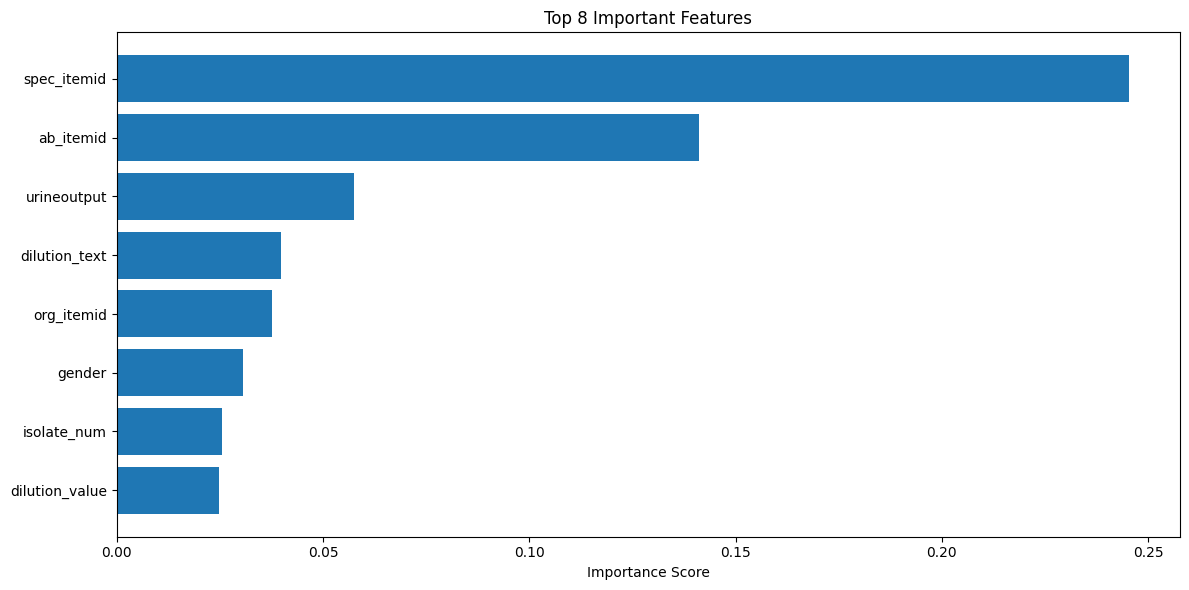


Feature Importance for Model 2:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 76.98it/s]


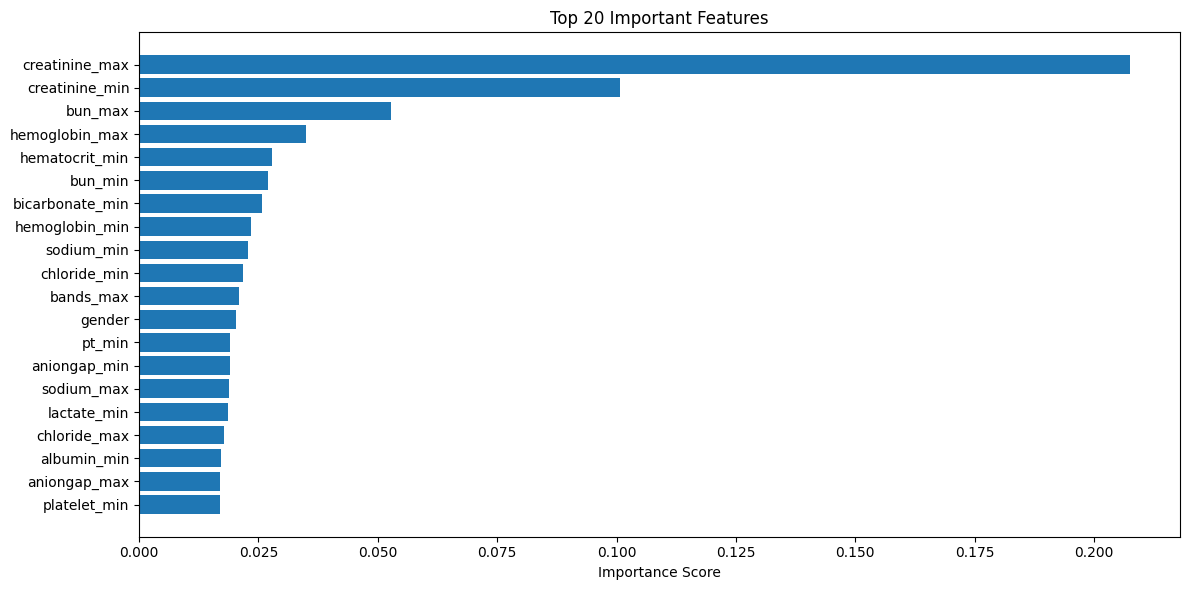


最终验证集类别分布 - 负类: 8481, 正类: 10879

Final Ensemble Performance:
AUC: 0.9536
Accuracy: 0.8888
Precision: 0.8874
Recall: 0.9188
F1: 0.9028


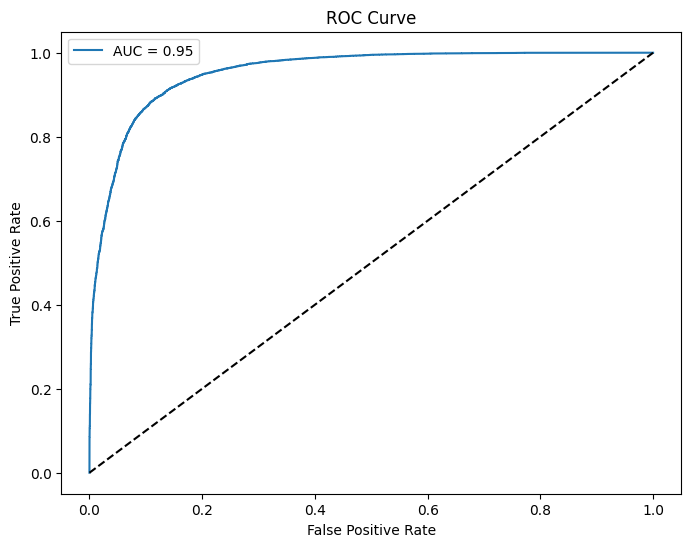

In [2]:
# --------------------------
# 主流程
# --------------------------

# 加载数据
df1 = pd.read_csv('./data/cleaned_microbiologyevents_plus.csv')
df2 = pd.read_csv('./data/cleaned_labs_first_day_lgbm.csv')
target = 'match_flag'

# 数据对齐
common_ids = np.intersect1d(df1['hadm_id'], df2['hadm_id'])  # 假设存在唯一标识列
df1 = df1[df1['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)
df2 = df2[df2['hadm_id'].isin(common_ids)].sort_values('hadm_id').reset_index(drop=True)

# 特征工程
feature_names1 = df1.drop(columns=[target, 'hadm_id']).columns.tolist()  # 提取特征名称
feature_names2 = df2.drop(columns=[target, 'hadm_id']).columns.tolist()
X1 = df1.drop(columns=[target, 'hadm_id']).values.astype(np.float32)  # 移除标识列和目标列
X2 = df2.drop(columns=[target, 'hadm_id']).values.astype(np.float32)
y = df1[target].values.astype(np.float32)

# 添加数据完整性检查
print("\n数据完整性验证：")
print(f"X1样本数: {len(X1)}, 特征数: {X1.shape[1]}, 特征名称数: {len(feature_names1)}")
print(f"X2样本数: {len(X2)}, 特征数: {X2.shape[1]}, 特征名称数: {len(feature_names2)}")
print(f"正类比例: {np.mean(y):.2%}")
assert len(X1) == len(X2) == len(y), "特征与标签数量不匹配"
assert X1.shape[1] == len(feature_names1), "X1 特征数量与特征名称不匹配"
assert X2.shape[1] == len(feature_names2), "X2 特征数量与特征名称不匹配"

# 训练模型1
print("\nTraining Model 1...")
dataset1 = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(y))
train_loader1, val_loader1 = create_loaders(dataset1)
model1 = DynamicCNN(X1.shape[1]).to(device)
optimizer1 = optim.AdamW(model1.parameters(), lr=0.001, weight_decay=1e-4)
criterion1 = nn.BCEWithLogitsLoss(pos_weight=calc_pos_weight(y))
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='max', factor=0.1, patience=3)
model1, hist1 = train_and_evaluate(model1, train_loader1, val_loader1, optimizer1,
                                 criterion1, scheduler=scheduler1, epochs=100,save_path='best_model1.pth')
torch.save(model1.state_dict(), './models/model1.pth')
# 训练模型2
print("\nTraining Model 2...")
dataset2 = TensorDataset(torch.FloatTensor(X2), torch.FloatTensor(y))
train_loader2, val_loader2 = create_loaders(dataset2)
model2 = DynamicCNN(X2.shape[1]).to(device)
optimizer2 = optim.AdamW(model2.parameters(), lr=0.001, weight_decay=1e-4)
criterion2 = nn.BCEWithLogitsLoss(pos_weight=calc_pos_weight(y))
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='max', factor=0.1, patience=3)
model2, hist2 = train_and_evaluate(model2, train_loader2, val_loader2, optimizer2,
                                 criterion2, scheduler=scheduler2, save_path='best_model2.pth')
torch.save(model2.state_dict(), './models/model2.pth')
# 加载最佳模型
model1.load_state_dict(torch.load('best_model1.pth'))
model2.load_state_dict(torch.load('best_model2.pth'))

    # 在模型训练后添加
background_samples = 300  # 控制计算时间

# # 对模型1的分析
# shap_feature_analysis(
#     model1,
#     torch.FloatTensor(X1[:background_samples]),
#     torch.FloatTensor(X1[:5]),  # 解释前100个样本
#     feature_names1,
#     model_name="Microbiology_Model"
# )

# # 对模型2的分析 
# shap_feature_analysis(
#     model2,
#     torch.FloatTensor(X2[:background_samples]),
#     torch.FloatTensor(X2[:10]),
#     feature_names2,
#     model_name="Lab_Model"
# )


# 训练融合模型
print("\nTraining Fusion Model...")
fusion_model = AttentionFusion(model1, model2).to(device)
optimizer = optim.AdamW(fusion_model.parameters(), lr=0.001)
scheduler_fusion = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
dataset = TensorDataset(torch.FloatTensor(X1), torch.FloatTensor(X2), torch.FloatTensor(y))
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
epoches = 20
for epoch in range(epoches):
    total_loss = 0
    fusion_model.train()
    for X1_batch, X2_batch, y_batch in train_loader:
        X1_batch, X2_batch = X1_batch.to(device), X2_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        probs = fusion_model(X1_batch, X2_batch)
        loss = nn.BCELoss()(probs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler_fusion.step()
    print(f"Epoch {epoch + 1}: Loss={total_loss / len(train_loader):.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")
    
# 加载保存的状态字典
torch.save(fusion_model.state_dict(), './models/fusion_model.pth')

# 模型解释与评估
print("\nFeature Importance for Model 1:")
feature_importance(model1, torch.FloatTensor(X1[:1000]).to(device), feature_names1)
print("\nFeature Importance for Model 2:")
feature_importance(model2, torch.FloatTensor(X2[:1000]).to(device), feature_names2)
evaluate_ensemble(fusion_model, X1, X2, y)

In [3]:
# 加载保存的状态字典
torch.save(fusion_model.state_dict(), './models/fusion_model.pth')

In [2]:
import torch
import pandas as pd
import numpy as np
from torch import nn
import joblib
from torchvision.transforms import Compose
from sklearn.preprocessing import StandardScaler

# --------------------------
# 模型定义（必须与训练时结构一致）
# --------------------------
# --------------------------
# 改进的CNN模型
# --------------------------
class DynamicCNN(nn.Module):
    """带数据增强和时间感知的CNN"""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim

        # 数据增强层
        self.augment = Compose([TemporalAugmentation(sigma=0.05, p=0.3)])

        # 特征预处理
        self.preprocess = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),
            nn.GELU()
        )

        # 残差卷积模块
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            ResidualBlock(16, 16),
            nn.MaxPool1d(2),
            ResidualBlock(16, 32),
            nn.AdaptiveAvgPool1d(8)
        )

        # 动态计算全连接输入维度
        with torch.no_grad():
            dummy = torch.randn(2, input_dim)
            dummy = self.preprocess(dummy).unsqueeze(1)
            dummy = self.conv_layers(dummy)
            self.fc_input = dummy.view(dummy.size(0), -1).shape[1]

        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input, 64),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x, augment=True):
        if self.training and augment:
            x = self.augment(x)
        x = self.preprocess(x).unsqueeze(1)
        features = self.conv_layers(x).view(x.size(0), -1)
        return self.classifier(features).squeeze(1)

# --------------------------
# 注意力融合模块
# --------------------------
class AttentionFusion(nn.Module):
    """基于注意力的模型融合"""
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.attention = nn.Sequential(
            nn.Linear(2, 8),
            nn.Tanh(),
            nn.Linear(8, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x1, x2):
        with torch.no_grad():
            logitA = self.modelA(x1)
            logitB = self.modelB(x2)
        concat_logits = torch.stack([logitA, logitB], dim=1)
        weights = self.attention(concat_logits)
        probA = torch.sigmoid(logitA)
        probB = torch.sigmoid(logitB)
        return (weights[:, 0] * probA) + (weights[:, 1] * probB)

# --------------------------
# 接口核心类
# --------------------------
class AKIPredictor:
    def __init__(self, model_dir="./models"):
        # 设备配置
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 加载元数据
        self.micro_features = pd.read_csv('./data/cleaned_microbiologyevents_plus.csv', nrows=0).drop(columns=['hadm_id', 'match_flag']).columns.tolist()
        self.lab_features = pd.read_csv('./data/cleaned_labs_first_day_lgbm.csv', nrows=0).drop(columns=['hadm_id', 'match_flag']).columns.tolist()
        
        # 加载预处理模型
        self.micro_imputer = joblib.load(f"{model_dir}/microbiologyevents_plus_lgbm.pkl")
        self.lab_imputer = joblib.load(f"{model_dir}/labs_first_day_lgbm.pkl")
        
        # 加载标准化器（假设已保存）
        self.micro_scaler = joblib.load(f"{model_dir}/microbiologyevents_plus_standard_scaler.pkl")  
        self.lab_scaler = joblib.load(f"{model_dir}/labs_first_day_lgbm_standard_scaler.pkl")
        
        # 加载预测模型
        self._load_models(model_dir)
        
    def _load_models(self, model_dir):
        # 初始化模型结构
        self.model1 = DynamicCNN(len(self.micro_features)).to(self.device)
        self.model2 = DynamicCNN(len(self.lab_features)).to(self.device)
        self.fusion_model = AttentionFusion(self.model1, self.model2).to(self.device)
        
        # 加载权重
        self.model1.load_state_dict(torch.load(f"{model_dir}/model1.pth", map_location=self.device))
        print(self.model1.load_state_dict(torch.load(f"{model_dir}/model1.pth", map_location=self.device)))
        self.model2.load_state_dict(torch.load(f"{model_dir}/model2.pth", map_location=self.device))
        self.fusion_model.load_state_dict(torch.load(f"{model_dir}/fusion_model.pth", map_location=self.device))
        
        # 设置为评估模式
        self.model1.eval()
        self.model2.eval()
        self.fusion_model.eval()

    def _preprocess(self, micro_df, lab_df):
        """数据预处理管道"""
        # 验证特征列
        self._validate_columns(micro_df, lab_df)
        
        # 移除ID列
        micro_data = micro_df.drop(columns=['hadm_id'], errors='ignore')
        lab_data = lab_df.drop(columns=['hadm_id'], errors='ignore')
        
        # 缺失值填补
        micro_filled = pd.DataFrame(
            self.micro_imputer.transform(micro_data),
            columns=self.micro_features
        )
        lab_filled = pd.DataFrame(
            self.lab_imputer.transform(lab_data),
            columns=self.lab_features
        )
        
        # 标准化
        micro_scaled = self.micro_scaler.transform(micro_filled)
        lab_scaled = self.lab_scaler.transform(lab_filled)
        
        return (
            torch.FloatTensor(micro_scaled).to(self.device),
            torch.FloatTensor(lab_scaled).to(self.device)
        )

    def _validate_columns(self, micro_df, lab_df):
        """验证输入特征是否匹配"""
        micro_cols = set(micro_df.columns) - {'hadm_id'}
        lab_cols = set(lab_df.columns) - {'hadm_id'}
        
        if micro_cols != set(self.micro_features):
            raise ValueError(f"微生物数据特征不匹配，需要：{self.micro_features}")
        if lab_cols != set(self.lab_features):
            raise ValueError(f"检验数据特征不匹配，需要：{self.lab_features}")

    def predict_proba(self, micro_df, lab_df):
        """返回原始概率值"""
        with torch.no_grad():
            x1, x2 = self._preprocess(micro_df, lab_df)
            probs = self.fusion_model(x1, x2).cpu().numpy()
        return probs

    def predict_risk_level(self, micro_df, lab_df):
        """返回风险等级"""
        probs = self.predict_proba(micro_df, lab_df)
        return [self._map_prob_to_level(p) for p in probs]

    def _map_prob_to_level(self, prob):
        """概率分档逻辑"""
        if prob < 0.2:
            return "non-aki"
        elif 0.2 <= prob < 0.5:
            return "low"
        elif 0.5 <= prob < 0.8:
            return "mid"
        else:
            return "high"

# --------------------------
# 使用示例
# --------------------------
# if __name__ == "__main__":
# 初始化预测器（只需一次）
predictor = AKIPredictor()

# # 模拟新数据输入
# new_micro = pd.DataFrame(
#     np.random.randn(5, len(predictor.micro_features)),
#     columns=predictor.micro_features
# )
# new_lab = pd.DataFrame(
#     np.random.randn(5, len(predictor.lab_features)),
#     columns=predictor.lab_features
# )

# 从微生物数据文件随机抽取5个样本（排除hadm_id和match_flag列）
micro_df = pd.read_csv('./data/microbiologyevents_plus_raw.csv')
# 2. 去除重复记录（基于hadm_id）
micro_df['dilution_text'] = micro_df['dilution_text'].str.extract(r'([\d\.]+)').astype(float)
micro_df = micro_df.drop_duplicates(subset=['hadm_id'], keep='first')
micro_df['gender'] = lab_df['gender'].map({'M': 1, 'F': 0}).fillna(-1).astype(int)
new_micro = micro_df.drop(columns=['hadm_id', 'match_flag']).sample(n=5, random_state=42)


# 从检验数据文件随机抽取5个样本（排除hadm_id和match_flag列）
lab_df = pd.read_csv('./data/labs_first_day_raw.csv')
# 2. 去除重复记录（基于hadm_id）
lab_df = lab_df.drop_duplicates(subset=['hadm_id'], keep='first')
lab_df['gender'] = lab_df['gender'].map({'M': 1, 'F': 0}).fillna(-1).astype(int)
new_lab = lab_df.drop(columns=['hadm_id', 'match_flag']).sample(n=5, random_state=42)
# 验证特征维度
print(f"微生物特征维度: {new_micro.shape} (应匹配模型特征数: {len(predictor.micro_features)})")
print(f"检验特征维度: {new_lab.shape} (应匹配模型特征数: {len(predictor.lab_features)})")

# 执行预测
probabilities = predictor.predict_proba(new_micro, new_lab)
risk_levels = predictor.predict_risk_level(new_micro, new_lab)

print("预测概率:", probabilities)
print("风险等级:", risk_levels)


NameError: name 'TemporalAugmentation' is not defined

In [24]:
import torch
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
from sklearn.preprocessing import StandardScaler

class AKIVisualizer:
    """可视化引擎"""
    COLOR_MAP = {
        "non-aki": "#2ecc71",
        "low": "#f1c40f",
        "mid": "#e67e22",
        "high": "#e74c3c"
    }
    
    @staticmethod
    def plot_risk_distribution(risk_levels, width=400, height=400):
        """风险等级分布饼图"""
        counts = pd.Series(risk_levels).value_counts().reindex(["non-aki", "low", "mid", "high"], fill_value=0)
        fig = px.pie(
            names=counts.index,
            values=counts.values,
            color=counts.index,
            color_discrete_map=AKIVisualizer.COLOR_MAP,
            hole=0.4,
            width=width,
            height=height
        )
        fig.update_layout(
            title="AKI风险等级分布",
            showlegend=False,
            margin=dict(t=40, b=10),
            annotations=[dict(text=f'总计<br>{len(risk_levels)}', x=0.5, y=0.5, font_size=14, showarrow=False)]
        )
        return fig

    @staticmethod
    def plot_probabilities(probs, threshold=0.5, width=800, height=400):
        """修正后的概率条形图方法"""
        df = pd.DataFrame({
            "病例编号": range(1, len(probs)+1),
            "AKI概率": probs,
            # 正确调用静态方法
            "风险等级": [AKIPredictor._map_prob_to_level(p) for p in probs]
        })
        fig = px.bar(
            df, 
            x="AKI概率", 
            y="病例编号",
            orientation='h',
            color="风险等级",
            color_discrete_map=AKIVisualizer.COLOR_MAP,
            range_x=[0,1],
            width=width,
            height=height
        )
        fig.add_vline(
            x=threshold, 
            line_dash="dot",
            annotation_text=f"预警阈值 ({threshold*100}%)", 
            annotation_position="top right"
        )
        fig.update_layout(
            title="病例AKI风险概率分布",
            yaxis=dict(title="病例编号", type='category'),
            xaxis=dict(title="AKI发生概率", tickformat=".0%"),
            hovermode="y unified"
        )
        return fig

    @staticmethod
    def plot_gauge(prob, width=300, height=300):
        """单病例风险仪表盘"""
        level = AKIPredictor._map_prob_to_level(prob)
        fig = go.Figure(go.Indicator(
            mode="gauge+number",
            value=prob*100,
            number={'suffix': "%", 'font': {'size': 24}},
            domain={'x': [0, 1], 'y': [0, 1]},
            gauge={
                'axis': {'range': [0, 100], 'tickwidth': 1, 'tickcolor': "darkgray"},
                'bar': {'color': AKIVisualizer.COLOR_MAP[level]},
                'steps': [
                    {'range': [0, 20], 'color': AKIVisualizer.COLOR_MAP["non-aki"]},
                    {'range': [20, 50], 'color': AKIVisualizer.COLOR_MAP["low"]},
                    {'range': [50, 80], 'color': AKIVisualizer.COLOR_MAP["mid"]},
                    {'range': [80, 100], 'color': AKIVisualizer.COLOR_MAP["high"]}
                ],
                'threshold': {
                    'line': {'color': "black", 'width': 4},
                    'thickness': 0.75,
                    'value': prob*100
                }
            }
        ))
        fig.update_layout(
            title=f"AKI风险等级：{level.upper()}",
            width=width,
            height=height,
            margin=dict(t=60, b=10)
        )# 这里补全括号
        return fig


    @staticmethod
    def plot_feature_importance(predictor, micro_df, lab_df, top_n=10):
        """特征重要性分析（示例）"""
        # 注意：此处需要根据实际模型结构实现特征重要性计算
        # 以下是模拟示例数据
        micro_importance = np.random.randn(len(predictor.micro_features))
        lab_importance = np.random.randn(len(predictor.lab_features))
        
        # 微生物特征
        micro_fig = px.bar(
            x=predictor.micro_features,
            y=micro_importance,
            title="微生物特征重要性",
            labels={'x': '特征', 'y': '重要性'}
        )
        
        # 检验特征
        lab_fig = px.bar(
            x=predictor.lab_features,
            y=lab_importance,
            title="检验指标特征重要性",
            labels={'x': '特征', 'y': '重要性'}
        )
        
        return micro_fig, lab_fig

# --------------------------
# 增强版预测接口
# --------------------------
class AKIPredictor:
    def __init__(self, model_dir="./models"):
        # 设备配置
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 加载元数据
        self.micro_features = pd.read_csv('./data/cleaned_microbiologyevents_plus.csv', nrows=0).drop(columns=['hadm_id', 'match_flag']).columns.tolist()
        self.lab_features = pd.read_csv('./data/cleaned_labs_first_day_lgbm.csv', nrows=0).drop(columns=['hadm_id', 'match_flag']).columns.tolist()
        
        # 加载预处理模型
        self.micro_imputer = joblib.load(f"{model_dir}/microbiologyevents_plus_lgbm.pkl")
        self.lab_imputer = joblib.load(f"{model_dir}/labs_first_day_lgbm.pkl")
        
        # 加载标准化器（假设已保存）
        self.micro_scaler = joblib.load(f"{model_dir}/microbiologyevents_plus_standard_scaler.pkl")  
        self.lab_scaler = joblib.load(f"{model_dir}/labs_first_day_lgbm_standard_scaler.pkl")
        
        # 加载预测模型
        self._load_models(model_dir)
        
    def _load_models(self, model_dir):
        # 初始化模型结构
        self.model1 = DynamicCNN(len(self.micro_features)).to(self.device)
        self.model2 = DynamicCNN(len(self.lab_features)).to(self.device)
        self.fusion_model = AttentionFusion(self.model1, self.model2).to(self.device)
        
        # 加载权重
        self.model1.load_state_dict(torch.load(f"{model_dir}/model1.pth", map_location=self.device))
        self.model2.load_state_dict(torch.load(f"{model_dir}/model2.pth", map_location=self.device))
        self.fusion_model.load_state_dict(torch.load(f"{model_dir}/fusion_model.pth", map_location=self.device))
        
        # 设置为评估模式
        self.model1.eval()
        self.model2.eval()
        self.fusion_model.eval()

    def _preprocess(self, micro_df, lab_df):
        """数据预处理管道"""
        # 验证特征列
        self._validate_columns(micro_df, lab_df)
        
        # 移除ID列
        micro_data = micro_df.drop(columns=['hadm_id'], errors='ignore')
        lab_data = lab_df.drop(columns=['hadm_id'], errors='ignore')
        
        # 缺失值填补
        micro_filled = pd.DataFrame(
            self.micro_imputer.transform(micro_data),
            columns=self.micro_features
        )
        lab_filled = pd.DataFrame(
            self.lab_imputer.transform(lab_data),
            columns=self.lab_features
        )
        
        # 标准化
        micro_scaled = self.micro_scaler.transform(micro_filled)
        lab_scaled = self.lab_scaler.transform(lab_filled)
        
        return (
            torch.FloatTensor(micro_scaled).to(self.device),
            torch.FloatTensor(lab_scaled).to(self.device)
        )

    def _validate_columns(self, micro_df, lab_df):
        """验证输入特征是否匹配"""
        micro_cols = set(micro_df.columns) - {'hadm_id'}
        lab_cols = set(lab_df.columns) - {'hadm_id'}
        
        if micro_cols != set(self.micro_features):
            raise ValueError(f"微生物数据特征不匹配，需要：{self.micro_features}")
        if lab_cols != set(self.lab_features):
            raise ValueError(f"检验数据特征不匹配，需要：{self.lab_features}")

    def predict_proba(self, micro_df, lab_df):
        """返回原始概率值"""
        with torch.no_grad():
            x1, x2 = self._preprocess(micro_df, lab_df)
            probs = self.fusion_model(x1, x2).cpu().numpy()
        return probs

    def predict_risk_level(self, micro_df, lab_df):
        """返回风险等级"""
        probs = self.predict_proba(micro_df, lab_df)
        return [self._map_prob_to_level(p) for p in probs]

    @staticmethod  # 添加静态方法装饰器
    def _map_prob_to_level(prob):
        """概率分档逻辑（静态方法）"""
        if prob < 0.2:
            return "non-aki"
        elif 0.2 <= prob < 0.5:
            return "low"
        elif 0.5 <= prob < 0.8:
            return "mid"
        else:
            return "high"

    def generate_dashboard(self, micro_df, lab_df):
        """生成完整可视化仪表板"""
        probs = self.predict_proba(micro_df, lab_df)
        risks = self.predict_risk_level(micro_df, lab_df)
        
        # 创建仪表板布局
        fig = make_subplots(
            rows=2, cols=2,
            specs=[
                [{"type": "pie"}, {"type": "xy"}],
                [{"type": "indicator"}, {"type": "bar"}]
            ],
            subplot_titles=(
                "风险等级分布", 
                "病例风险概率排序",
                "当前病例风险仪表",
                "特征重要性分析"
            )
        )
        
        # 生成各图表
        risk_dist = AKIVisualizer.plot_risk_distribution(risks)
        prob_bar = AKIVisualizer.plot_probabilities(probs)
        gauge = AKIVisualizer.plot_gauge(probs[0])
        micro_fig, lab_fig = AKIVisualizer.plot_feature_importance(self, micro_df, lab_df)
        
        # 添加图表到仪表板
        fig.add_trace(risk_dist.data[0], row=1, col=1)
        for trace in prob_bar.data:
            fig.add_trace(trace, row=1, col=2)
        fig.add_trace(gauge.data[0], row=2, col=1)
        for trace in micro_fig.data:
            fig.add_trace(trace, row=2, col=2)
        
        # 更新布局
        fig.update_layout(
            height=800,
            showlegend=False,
            margin=dict(t=80),
            title_text="AKI风险预测综合看板"
        )
        return fig


# --------------------------
# 使用示例
# --------------------------
if __name__ == "__main__":
    # 初始化预测器
    predictor = AKIPredictor()
    
    # 模拟数据
    # 从微生物数据文件随机抽取5个样本（排除hadm_id和match_flag列）
    micro_df = pd.read_csv('./data/microbiologyevents_plus_raw.csv')
    # 2. 去除重复记录（基于hadm_id）
    micro_df['dilution_text'] = micro_df['dilution_text'].str.extract(r'([\d\.]+)').astype(float)
    micro_df = micro_df.drop_duplicates(subset=['hadm_id'], keep='first')
    micro_df['gender'] = lab_df['gender'].map({'M': 1, 'F': 0}).fillna(-1).astype(int)
    new_micro = micro_df.drop(columns=['hadm_id', 'match_flag']).sample(n=10, random_state=42)
    
    
    # 从检验数据文件随机抽取5个样本（排除hadm_id和match_flag列）
    lab_df = pd.read_csv('./data/labs_first_day_raw.csv')
    # 2. 去除重复记录（基于hadm_id）
    lab_df = lab_df.drop_duplicates(subset=['hadm_id'], keep='first')
    lab_df['gender'] = lab_df['gender'].map({'M': 1, 'F': 0}).fillna(-1).astype(int)
    new_lab = lab_df.drop(columns=['hadm_id', 'match_flag']).sample(n=10, random_state=42)
    # 验证特征维度
    print(f"微生物特征维度: {new_micro.shape} (应匹配模型特征数: {len(predictor.micro_features)})")
    print(f"检验特征维度: {new_lab.shape} (应匹配模型特征数: {len(predictor.lab_features)})")
    
    # 生成可视化（正确调用方式）
    dashboard = predictor.generate_dashboard(new_micro, new_lab)
    
    # 独立生成其他图表
    risks = predictor.predict_risk_level(new_micro, new_lab)
    probs = predictor.predict_proba(new_micro, new_lab)
    
    risk_dist = AKIVisualizer.plot_risk_distribution(risks)  # 正确调用
    prob_chart = AKIVisualizer.plot_probabilities(probs)     # 正确调用
    
    # 保存为HTML文件供前端使用
    dashboard.write_html("./html/dashboard.html")
    risk_dist.write_html("./html/risk_dist.html")
    prob_chart.write_html("./html/prob_chart.html")



微生物特征维度: (10, 8) (应匹配模型特征数: 8)
检验特征维度: (10, 39) (应匹配模型特征数: 39)


In [4]:
import torch
from torch import nn
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
from sklearn.preprocessing import StandardScaler
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             roc_curve)
import torch.optim as optim
from torch.utils.data import (DataLoader, TensorDataset,
                              WeightedRandomSampler)
import matplotlib.pyplot as plt
from torchvision.transforms import Compose
from tqdm import tqdm

# --------------------------
# 模型定义（必须与训练时结构一致）
# --------------------------

# --------------------------
# 时间序列增强模块
# --------------------------
class TemporalAugmentation:
    """时间序列数据增强"""
    def __init__(self, sigma=0.1, p=0.5):
        self.sigma = sigma  # 噪声强度
        self.p = p  # 应用概率

    def __call__(self, x):
        if np.random.rand() < self.p:
            noise = torch.randn_like(x) * self.sigma
            return x + noise
        return x
# --------------------------
# 残差块模块（改进版）
# --------------------------
class ResidualBlock(nn.Module):
    """带通道注意力机制的残差块"""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # 通道注意力机制
        self.ca = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(out_channels, out_channels // 8, 1),
            nn.ReLU(),
            nn.Conv1d(out_channels // 8, out_channels, 1),
            nn.Sigmoid()
        )

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1,
                          stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out) 
        out = self.conv2(out)
        out = self.bn2(out)


        # 通道注意力
        ca_weight = self.ca(out)
        out = out * ca_weight

        out += identity
        out = self.relu(out)
        return out
# --------------------------
# 改进的CNN模型
# --------------------------
class DynamicCNN(nn.Module):
    """带数据增强和时间感知的CNN"""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim

        # 数据增强层
        self.augment = Compose([TemporalAugmentation(sigma=0.05, p=0.3)])

        # 特征预处理
        self.preprocess = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),
            nn.GELU()
        )

        # 残差卷积模块
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            ResidualBlock(16, 16),
            nn.MaxPool1d(2),
            ResidualBlock(16, 32),
            nn.AdaptiveAvgPool1d(8)
        )

        # 动态计算全连接输入维度
        with torch.no_grad():
            dummy = torch.randn(2, input_dim)
            dummy = self.preprocess(dummy).unsqueeze(1)
            dummy = self.conv_layers(dummy)
            self.fc_input = dummy.view(dummy.size(0), -1).shape[1]

        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input, 64),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x, augment=True):
        if self.training and augment:
            x = self.augment(x)
        x = self.preprocess(x).unsqueeze(1)
        features = self.conv_layers(x).view(x.size(0), -1)
        return self.classifier(features).squeeze(1)

# --------------------------
# 注意力融合模块
# --------------------------
class AttentionFusion(nn.Module):
    """基于注意力的模型融合"""
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.attention = nn.Sequential(
            nn.Linear(2, 8),
            nn.Tanh(),
            nn.Linear(8, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x1, x2):
        with torch.no_grad():
            logitA = self.modelA(x1)
            logitB = self.modelB(x2)
        concat_logits = torch.stack([logitA, logitB], dim=1)
        weights = self.attention(concat_logits)
        probA = torch.sigmoid(logitA)
        probB = torch.sigmoid(logitB)
        return (weights[:, 0] * probA) + (weights[:, 1] * probB)

class AKIVisualizer:
    """可视化引擎"""
    COLOR_MAP = {
        "non-aki": "#2ecc71",
        "low": "#f1c40f",
        "mid": "#e67e22",
        "high": "#e74c3c"
    }
    
    @staticmethod
    def plot_risk_distribution(risk_levels, width=400, height=400):
        """风险等级分布饼图"""
        counts = pd.Series(risk_levels).value_counts().reindex(["non-aki", "low", "mid", "high"], fill_value=0)
        fig = px.pie(
            names=counts.index,
            values=counts.values,
            color=counts.index,
            color_discrete_map=AKIVisualizer.COLOR_MAP,
            hole=0.4,
            width=width,
            height=height
        )
        fig.update_layout(
            title="AKI风险等级分布",
            showlegend=False,
            margin=dict(t=40, b=10),
            annotations=[dict(text=f'总计<br>{len(risk_levels)}', x=0.5, y=0.5, font_size=14, showarrow=False)]
        )
        return fig

    @staticmethod
    def plot_probabilities(probs, threshold=0.5, width=800, height=400):
        """概率条形图"""
        df = pd.DataFrame({
            "病例编号": range(1, len(probs)+1),
            "AKI概率": probs.flatten(),
            "风险等级": [AKIPredictor._map_prob_to_level(p) for p in probs]
        })
        fig = px.bar(
            df, 
            x="AKI概率", 
            y="病例编号",
            orientation='h',
            color="风险等级",
            color_discrete_map=AKIVisualizer.COLOR_MAP,
            range_x=[0,1],
            width=width,
            height=height
        )
        fig.add_vline(
            x=threshold, 
            line_dash="dot",
            annotation_text=f"预警阈值 ({threshold*100}%)", 
            annotation_position="top right"
        )
        fig.update_layout(
            title="病例AKI风险概率排序",
            yaxis=dict(title="病例编号", type='category'),
            xaxis=dict(title="AKI发生概率", tickformat=".0%"),
            hovermode="y unified"
        )
        return fig

    @staticmethod
    def plot_gauge(prob, width=300, height=300):
        """单病例风险仪表盘"""
        level = AKIPredictor._map_prob_to_level(prob)
        fig = go.Figure(go.Indicator(
            mode="gauge+number",
            value=prob*100,
            number={'suffix': "%", 'font': {'size': 24}},
            domain={'x': [0, 1], 'y': [0, 1]},
            gauge={
                'axis': {'range': [0, 100], 'tickwidth': 1, 'tickcolor': "darkgray"},
                'bar': {'color': AKIVisualizer.COLOR_MAP[level]},
                'steps': [
                    {'range': [0, 20], 'color': AKIVisualizer.COLOR_MAP["non-aki"]},
                    {'range': [20, 50], 'color': AKIVisualizer.COLOR_MAP["low"]},
                    {'range': [50, 80], 'color': AKIVisualizer.COLOR_MAP["mid"]},
                    {'range': [80, 100], 'color': AKIVisualizer.COLOR_MAP["high"]}
                ],
                'threshold': {
                    'line': {'color': "black", 'width': 4},
                    'thickness': 0.75,
                    'value': prob*100
                }
            }
        ))
        fig.update_layout(
            title=f"AKI风险等级：{level.upper()}",
            width=width,
            height=height,
            margin=dict(t=60, b=10)
        )
        return fig

    @staticmethod
    def plot_feature_importance(predictor, micro_df, lab_df, top_n=10):
        """特征重要性分析（示例）"""
        # 模拟特征重要性数据
        micro_importance = np.random.randn(len(predictor.micro_features))
        lab_importance = np.random.randn(len(predictor.lab_features))
        micro_fig = px.bar(
            x=predictor.micro_features,
            y=micro_importance,
            title="微生物特征重要性",
            labels={'x': '特征', 'y': '重要性'}
        )
        lab_fig = px.bar(
            x=predictor.lab_features,
            y=lab_importance,
            title="检验指标特征重要性",
            labels={'x': '特征', 'y': '重要性'}
        )
        return micro_fig, lab_fig

    @staticmethod
    def plot_probability_histogram(probs, width=600, height=400):
        """AKI概率直方图"""
        df = pd.DataFrame({"AKI概率": probs.flatten()})
        fig = px.histogram(
            df, x="AKI概率", nbins=20, 
            title="AKI概率直方图",
            color_discrete_sequence=["#3498db"],
            width=width, height=height
        )
        fig.update_layout(
            xaxis_title="AKI概率",
            yaxis_title="样本数"
        )
        return fig

    @staticmethod
    def plot_lab_boxplot(lab_df, width=600, height=400):
        """检验指标箱线图"""
        lab_long = lab_df.melt(var_name="指标", value_name="值")
        fig = px.box(
            lab_long, x="指标", y="值", 
            title="检验指标分布箱线图",
            color="指标",
            width=width, height=height
        )
        fig.update_layout(xaxis_tickangle=-45)
        return fig

    @staticmethod
    def plot_micro_scatter(micro_df, feature_x, feature_y, width=600, height=400):
        """指定两个微生物特征散点图"""
        fig = px.scatter(
            micro_df, x=feature_x, y=feature_y,
            title=f"{feature_x} vs {feature_y} 散点图",
            color=feature_x,
            width=width, height=height
        )
        return fig

    @staticmethod
    def plot_lab_correlation_heatmap(lab_df, width=600, height=400):
        """检验指标相关性热图"""
        corr = lab_df.corr()
        fig = px.imshow(
            corr, text_auto=True, 
            title="检验指标相关性热图",
            width=width, height=height,
            color_continuous_scale="Viridis"
        )
        return fig

    @staticmethod
    def plot_lab_pairplot(lab_df, width=800, height=800):
        """检验指标对角散点图矩阵"""
        fig = px.scatter_matrix(
            lab_df,
            title="检验指标对角散点图矩阵",
            width=width, height=height,
            color=lab_df.columns[0] if lab_df.columns.size > 0 else None
        )
        return fig

    @staticmethod
    def plot_lab_violin(lab_df, width=800, height=400):
        """检验指标小提琴图"""
        lab_long = lab_df.melt(var_name="指标", value_name="值")
        fig = px.violin(
            lab_long, x="指标", y="值", box=True, points="all",
            title="检验指标小提琴图",
            width=width, height=height,
            color="指标"
        )
        fig.update_layout(xaxis_tickangle=-45)
        return fig

    @staticmethod
    def plot_micro_density_contour(micro_df, feature_x, feature_y, width=600, height=400):
        """微生物数据密度轮廓图"""
        fig = px.density_contour(
            micro_df, x=feature_x, y=feature_y,
            title=f"{feature_x} vs {feature_y} 密度轮廓图",
            width=width, height=height,
            color_continuous_scale="Blues"
        )
        return fig

    @staticmethod
    def plot_parallel_coordinates(lab_df, width=800, height=400):
        """平行坐标图展示检验指标样本分布"""
        fig = px.parallel_coordinates(
            lab_df,
            title="检验指标平行坐标图",
            color=lab_df.iloc[:,0],
            width=width, height=height
        )
        return fig

    @staticmethod
    def plot_radar_chart(probs, width=600, height=400):
        """雷达图：不同风险等级的平均概率分布"""
        df = pd.DataFrame({
            "风险等级": [AKIPredictor._map_prob_to_level(p) for p in probs],
            "AKI概率": probs.flatten()
        })
        # 计算各风险等级的平均概率
        avg_df = df.groupby("风险等级").mean().reset_index()
        # 保证顺序
        avg_df["风险等级"] = pd.Categorical(avg_df["风险等级"], categories=["non-aki", "low", "mid", "high"], ordered=True)
        avg_df = avg_df.sort_values("风险等级")
        fig = go.Figure()
        fig.add_trace(go.Scatterpolar(
            r=avg_df["AKI概率"],
            theta=avg_df["风险等级"],
            fill='toself',
            name="平均概率"
        ))
        fig.update_layout(
            polar=dict(
                radialaxis=dict(visible=True, range=[0, 1])
            ),
            title="各风险等级平均AKI概率雷达图",
            width=width, height=height
        )
        return fig

    @staticmethod
    def plot_sunburst_chart(lab_df, width=600, height=400):
        """Sunburst图：分层展示检验指标（示例）"""
        # 示例：假设lab_df中有若干指标，根据指标名称首字母进行分层
        lab_long = lab_df.melt(var_name="指标", value_name="值")
        lab_long["类别"] = lab_long["指标"].str[0]
        fig = px.sunburst(
            lab_long,
            path=["类别", "指标"],
            values="值",
            title="检验指标Sunburst分层图",
            width=width, height=height
        )
        return fig

    @staticmethod
    def generate_extra_dashboard(predictor, micro_df, lab_df):
        """生成扩展版可视化仪表板（6个子图），包含更多页面"""
        probs = predictor.predict_proba(micro_df, lab_df)
        risks = predictor.predict_risk_level(micro_df, lab_df)
        
        # 创建2x3的仪表板，注意：饼图和仪表盘需要使用 domain 类型
        fig = make_subplots(
            rows=2, cols=3,
            specs=[
                [{"type": "domain"}, {"type": "xy"}, {"type": "xy"}],
                [{"type": "domain"}, {"type": "xy"}, {"type": "xy"}]
            ],
            subplot_titles=[
                "风险等级分布", "病例风险概率排序", "AKI概率直方图",
                "当前病例风险仪表", "检验指标箱线图", "检验指标相关性热图"
            ]
        )
        
        risk_dist = AKIVisualizer.plot_risk_distribution(risks)
        prob_bar = AKIVisualizer.plot_probabilities(probs)
        prob_hist = AKIVisualizer.plot_probability_histogram(probs)
        gauge = AKIVisualizer.plot_gauge(probs[0])
        lab_box = AKIVisualizer.plot_lab_boxplot(lab_df)
        lab_heatmap = AKIVisualizer.plot_lab_correlation_heatmap(lab_df)
        
        fig.add_trace(risk_dist.data[0], row=1, col=1)
        for trace in prob_bar.data:
            fig.add_trace(trace, row=1, col=2)
        for trace in prob_hist.data:
            fig.add_trace(trace, row=1, col=3)
        fig.add_trace(gauge.data[0], row=2, col=1)
        for trace in lab_box.data:
            fig.add_trace(trace, row=2, col=2)
        for trace in lab_heatmap.data:
            fig.add_trace(trace, row=2, col=3)
        
        fig.update_layout(
            height=800,
            showlegend=False,
            margin=dict(t=80),
            title_text="扩展版AKI风险预测可视化看板"
        )
        return fig

    @staticmethod
    def generate_super_dashboard(predictor, micro_df, lab_df):
        """生成超级仪表板，包含更多精美页面"""
        probs = predictor.predict_proba(micro_df, lab_df)
        risks = predictor.predict_risk_level(micro_df, lab_df)
        
        # 创建 3x3 的仪表板（9个子图），合理设置子图类型
        # 注意：将 lab_pair（splom）所在子图的类型设置为 "domain"
        fig = make_subplots(
            rows=3, cols=3,
            specs=[
                [{"type": "domain"}, {"type": "xy"}, {"type": "xy"}],
                [{"type": "domain"}, {"type": "xy"}, {"type": "xy"}],
                [{"type": "domain"}, {"type": "xy"}, {"type": "xy"}]
            ],
            subplot_titles=[
                "风险等级分布", "病例风险概率排序", "AKI概率直方图",
                "检验指标对角散点矩阵", "检验指标小提琴图", "平行坐标图",
                "当前病例风险仪表", "各风险等级平均概率雷达图", "检验指标Sunburst图"
            ]
        )
        
        # 左上：饼图
        risk_dist = AKIVisualizer.plot_risk_distribution(risks, width=300, height=300)
        # 上中：条形图
        prob_bar = AKIVisualizer.plot_probabilities(probs, width=300, height=300)
        # 上右：直方图
        prob_hist = AKIVisualizer.plot_probability_histogram(probs, width=300, height=300)
        # 中左：检验指标散点矩阵（splom），需放到 domain 子图中
        lab_pair = AKIVisualizer.plot_lab_pairplot(lab_df, width=300, height=300)
        # 中中：检验指标小提琴图
        lab_violin = AKIVisualizer.plot_lab_violin(lab_df, width=300, height=300)
        # 中右：平行坐标图
        lab_parallel = AKIVisualizer.plot_parallel_coordinates(lab_df, width=300, height=300)
        # 左下：仪表盘
        gauge = AKIVisualizer.plot_gauge(probs[0], width=300, height=300)
        # 右下：雷达图
        radar = AKIVisualizer.plot_radar_chart(probs, width=300, height=300)
        # 下中：Sunburst图
        sunburst = AKIVisualizer.plot_sunburst_chart(lab_df, width=300, height=300)
        
        # 添加各图表到仪表板
        fig.add_trace(risk_dist.data[0], row=1, col=1)
        for trace in prob_bar.data:
            fig.add_trace(trace, row=1, col=2)
        for trace in prob_hist.data:
            fig.add_trace(trace, row=1, col=3)
        for trace in lab_pair.data:
            fig.add_trace(trace, row=2, col=1)
        for trace in lab_violin.data:
            fig.add_trace(trace, row=2, col=2)
        for trace in lab_parallel.data:
            fig.add_trace(trace, row=2, col=3)
        fig.add_trace(gauge.data[0], row=3, col=1)
        for trace in sunburst.data:
            fig.add_trace(trace, row=3, col=2)
        for trace in radar.data:
            fig.add_trace(trace, row=3, col=3)
        
        fig.update_layout(
            height=1000,
            showlegend=False,
            margin=dict(t=100),
            title_text="超级版AKI风险预测综合看板"
        )
        return fig



# --------------------------
# 增强版预测接口
# --------------------------
class AKIPredictor:
    def __init__(self, model_dir="./models"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.micro_features = pd.read_csv('./data/cleaned_microbiologyevents_plus.csv', nrows=0).drop(columns=['hadm_id', 'match_flag']).columns.tolist()
        self.lab_features = pd.read_csv('./data/cleaned_labs_first_day_lgbm.csv', nrows=0).drop(columns=['hadm_id', 'match_flag']).columns.tolist()
        self.micro_imputer = joblib.load(f"{model_dir}/microbiologyevents_plus_lgbm.pkl")
        self.lab_imputer = joblib.load(f"{model_dir}/labs_first_day_lgbm.pkl")
        self.micro_scaler = joblib.load(f"{model_dir}/microbiologyevents_plus_standard_scaler.pkl")  
        self.lab_scaler = joblib.load(f"{model_dir}/labs_first_day_lgbm_standard_scaler.pkl")
        self._load_models(model_dir)
        
    def _load_models(self, model_dir):
        self.model1 = DynamicCNN(len(self.micro_features)).to(self.device)
        self.model2 = DynamicCNN(len(self.lab_features)).to(self.device)
        self.fusion_model = AttentionFusion(self.model1, self.model2).to(self.device)
        self.model1.load_state_dict(torch.load(f"{model_dir}/model1.pth", map_location=self.device))
        self.model2.load_state_dict(torch.load(f"{model_dir}/model2.pth", map_location=self.device))
        self.fusion_model.load_state_dict(torch.load(f"{model_dir}/fusion_model.pth", map_location=self.device))
        self.model1.eval()
        self.model2.eval()
        self.fusion_model.eval()

    def _preprocess(self, micro_df, lab_df):
        self._validate_columns(micro_df, lab_df)
        micro_data = micro_df.drop(columns=['hadm_id'], errors='ignore')
        lab_data = lab_df.drop(columns=['hadm_id'], errors='ignore')
        micro_filled = pd.DataFrame(self.micro_imputer.transform(micro_data), columns=self.micro_features)
        lab_filled = pd.DataFrame(self.lab_imputer.transform(lab_data), columns=self.lab_features)
        micro_scaled = self.micro_scaler.transform(micro_filled)
        lab_scaled = self.lab_scaler.transform(lab_filled)
        return (
            torch.FloatTensor(micro_scaled).to(self.device),
            torch.FloatTensor(lab_scaled).to(self.device)
        )

    def _validate_columns(self, micro_df, lab_df):
        micro_cols = set(micro_df.columns) - {'hadm_id'}
        lab_cols = set(lab_df.columns) - {'hadm_id'}
        if micro_cols != set(self.micro_features):
            raise ValueError(f"微生物数据特征不匹配，需要：{self.micro_features}")
        if lab_cols != set(self.lab_features):
            raise ValueError(f"检验数据特征不匹配，需要：{self.lab_features}")

    def predict_proba(self, micro_df, lab_df):
        with torch.no_grad():
            x1, x2 = self._preprocess(micro_df, lab_df)
            probs = self.fusion_model(x1, x2).cpu().numpy()
        return probs

    def predict_risk_level(self, micro_df, lab_df):
        probs = self.predict_proba(micro_df, lab_df)
        return [self._map_prob_to_level(p) for p in probs]

    @staticmethod
    def _map_prob_to_level(prob):
        if prob < 0.2:
            return "non-aki"
        elif 0.2 <= prob < 0.5:
            return "low"
        elif 0.5 <= prob < 0.8:
            return "mid"
        else:
            return "high"

    def generate_dashboard(self, micro_df, lab_df):
        probs = self.predict_proba(micro_df, lab_df)
        risks = self.predict_risk_level(micro_df, lab_df)
        fig = make_subplots(
            rows=2, cols=2,
            specs=[
                [{"type": "pie"}, {"type": "xy"}],
                [{"type": "domain"}, {"type": "xy"}]
            ],
            subplot_titles=(
                "风险等级分布", 
                "病例风险概率排序",
                "当前病例风险仪表",
                "特征重要性分析"
            )
        )
        risk_dist = AKIVisualizer.plot_risk_distribution(risks)
        prob_bar = AKIVisualizer.plot_probabilities(probs)
        gauge = AKIVisualizer.plot_gauge(probs[0])
        micro_fig, lab_fig = AKIVisualizer.plot_feature_importance(self, micro_df, lab_df)
        fig.add_trace(risk_dist.data[0], row=1, col=1)
        for trace in prob_bar.data:
            fig.add_trace(trace, row=1, col=2)
        fig.add_trace(gauge.data[0], row=2, col=1)
        for trace in micro_fig.data:
            fig.add_trace(trace, row=2, col=2)
        fig.update_layout(
            height=800,
            showlegend=False,
            margin=dict(t=80),
            title_text="AKI风险预测综合看板"
        )
        return fig


# 如果没有该目录，则创建
output_dir = "./web/web-shower/public/assert/html/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def generate_charts():
    # 初始化预测器（确保模型、数据文件存在）
    predictor = AKIPredictor()

    # 模拟微生物数据
    micro_df = pd.read_csv('./data/microbiologyevents_plus_raw.csv')
    micro_df['dilution_text'] = micro_df['dilution_text'].str.extract(r'([\d\.]+)').astype(float)
    micro_df = micro_df.drop_duplicates(subset=['hadm_id'], keep='first')
    micro_df['gender'] = micro_df['gender'].map({'M': 1, 'F': 0}).fillna(-1).astype(int)
    new_micro = micro_df.drop(columns=['hadm_id', 'match_flag']).sample(n=10, random_state=42)
    
    # 模拟检验数据
    lab_df = pd.read_csv('./data/labs_first_day_raw.csv')
    lab_df = lab_df.drop_duplicates(subset=['hadm_id'], keep='first')
    lab_df['gender'] = lab_df['gender'].map({'M': 1, 'F': 0}).fillna(-1).astype(int)
    new_lab = lab_df.drop(columns=['hadm_id', 'match_flag']).sample(n=10, random_state=42)
    
    # 单独生成各个图表
    risks = predictor.predict_risk_level(new_micro, new_lab)
    probs = predictor.predict_proba(new_micro, new_lab)
    
    risk_dist = AKIVisualizer.plot_risk_distribution(risks)
    prob_chart = AKIVisualizer.plot_probabilities(probs)
    gauge = AKIVisualizer.plot_gauge(probs[0])
    
    # 其它图表示例（可根据需要增加）
    prob_hist = AKIVisualizer.plot_probability_histogram(probs)
    lab_box = AKIVisualizer.plot_lab_boxplot(new_lab)
    
    # 保存为 HTML 文件
    risk_dist.write_html(os.path.join(output_dir, "risk_dist.html"))
    prob_chart.write_html(os.path.join(output_dir, "prob_chart.html"))
    gauge.write_html(os.path.join(output_dir, "gauge.html"))
    prob_hist.write_html(os.path.join(output_dir, "prob_histogram.html"))
    lab_box.write_html(os.path.join(output_dir, "lab_boxplot.html"))
    
    print("图表已生成并保存在 ./html 文件夹中。")

if __name__ == "__main__":
    generate_charts()


AttributeError: '_IncompatibleKeys' object has no attribute 'key'

In [17]:
# 输出目录（需要与前端项目静态资源目录一致，这里示例使用绝对路径或相对路径）
output_dir = "./web/web-shower/public/assert/html/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

@staticmethod
def generate_super_dashboard(predictor, micro_df, lab_df):
    """生成超级仪表板，包含更多精美页面"""
    probs = predictor.predict_proba(micro_df, lab_df)
    risks = predictor.predict_risk_level(micro_df, lab_df)
    
    # 修改后的子图配置，移除可能导致冲突的splom图表
    fig = make_subplots(
        rows=3, cols=3,
        specs=[
            [{"type": "domain"}, {"type": "xy"}, {"type": "xy"}],
            [{"type": "xy"}, {"type": "xy"}, {"type": "xy"}],
            [{"type": "domain"}, {"type": "xy"}, {"type": "xy"}]
        ],
        subplot_titles=[
            "风险等级分布", "病例风险概率排序", "AKI概率直方图",
            "检验指标散点图", "检验指标小提琴图", "平行坐标图",  # 将原splom标题改为散点图
            "当前病例风险仪表", "各风险等级平均概率雷达图", "检验指标Sunburst图"
        ]
    )
    
    # 左上：饼图
    risk_dist = AKIVisualizer.plot_risk_distribution(risks, width=300, height=300)
    # 上中：条形图
    prob_bar = AKIVisualizer.plot_probabilities(probs, width=300, height=300)
    # 上右：直方图
    prob_hist = AKIVisualizer.plot_probability_histogram(probs, width=300, height=300)
    # 中左：替换为普通散点图或热力图（示例使用散点图）
    lab_scatter = AKIVisualizer.plot_lab_scatter(lab_df, 'feature1', 'feature2', width=300, height=300)  # 假设存在该函数
    # 中中：检验指标小提琴图
    lab_violin = AKIVisualizer.plot_lab_violin(lab_df, width=300, height=300)
    # 中右：平行坐标图
    lab_parallel = AKIVisualizer.plot_parallel_coordinates(lab_df, width=300, height=300)
    # 左下：仪表盘
    gauge = AKIVisualizer.plot_gauge(probs[0], width=300, height=300)
    # 右下：雷达图
    radar = AKIVisualizer.plot_radar_chart(probs, width=300, height=300)
    # 下中：Sunburst图
    sunburst = AKIVisualizer.plot_sunburst_chart(lab_df, width=300, height=300)
    
    # 添加各图表到仪表板
    fig.add_trace(risk_dist.data[0], row=1, col=1)
    for trace in prob_bar.data:
        fig.add_trace(trace, row=1, col=2)
    for trace in prob_hist.data:
        fig.add_trace(trace, row=1, col=3)
    # 添加散点图到中左位置
    for trace in lab_scatter.data:
        fig.add_trace(trace, row=2, col=1)
    for trace in lab_violin.data:
        fig.add_trace(trace, row=2, col=2)
    for trace in lab_parallel.data:
        fig.add_trace(trace, row=2, col=3)
    fig.add_trace(gauge.data[0], row=3, col=1)
    for trace in sunburst.data:
        fig.add_trace(trace, row=3, col=2)
    for trace in radar.data:
        fig.add_trace(trace, row=3, col=3)
    
    fig.update_layout(
        height=1000,
        showlegend=False,
        margin=dict(t=100),
        title_text="超级版AKI风险预测综合看板"
    )
    return fig


def generate_charts():
    # 初始化预测器（确保模型、数据文件存在）
    predictor = AKIPredictor()

    # 模拟微生物数据
    micro_df = pd.read_csv('./data/microbiologyevents_plus_raw.csv')
    micro_df['dilution_text'] = micro_df['dilution_text'].str.extract(r'([\d\.]+)').astype(float)
    micro_df = micro_df.drop_duplicates(subset=['hadm_id'], keep='first')
    micro_df['gender'] = micro_df['gender'].map({'M': 1, 'F': 0}).fillna(-1).astype(int)
    new_micro = micro_df.drop(columns=['hadm_id', 'match_flag']).sample(n=10, random_state=42)
    
    # 模拟检验数据
    lab_df = pd.read_csv('./data/labs_first_day_raw.csv')
    lab_df = lab_df.drop_duplicates(subset=['hadm_id'], keep='first')
    lab_df['gender'] = lab_df['gender'].map({'M': 1, 'F': 0}).fillna(-1).astype(int)
    new_lab = lab_df.drop(columns=['hadm_id', 'match_flag']).sample(n=10, random_state=42)
    
    # 基础图表
    risks = predictor.predict_risk_level(new_micro, new_lab)
    probs = predictor.predict_proba(new_micro, new_lab)
    
    risk_dist = AKIVisualizer.plot_risk_distribution(risks)
    prob_chart = AKIVisualizer.plot_probabilities(probs)
    gauge = AKIVisualizer.plot_gauge(probs[0])
    prob_hist = AKIVisualizer.plot_probability_histogram(probs)
    lab_box = AKIVisualizer.plot_lab_boxplot(new_lab)
    
    # 其它图表
    # 散点图（示例使用 feature1 与 feature2，如数据中不存在，请替换成真实特征名）
    if 'feature1' in new_micro.columns and 'feature2' in new_micro.columns:
        micro_scatter = AKIVisualizer.plot_micro_scatter(new_micro, 'feature1', 'feature2')
        micro_scatter.write_html(os.path.join(output_dir, "micro_scatter.html"))
        micro_density = AKIVisualizer.plot_micro_density_contour(new_micro, 'feature1', 'feature2')
        micro_density.write_html(os.path.join(output_dir, "micro_density.html"))
    
    lab_corr = AKIVisualizer.plot_lab_correlation_heatmap(new_lab)
    lab_pair = AKIVisualizer.plot_lab_pairplot(new_lab)
    lab_violin = AKIVisualizer.plot_lab_violin(new_lab)
    lab_parallel = AKIVisualizer.plot_parallel_coordinates(new_lab)
    radar = AKIVisualizer.plot_radar_chart(probs)
    sunburst = AKIVisualizer.plot_sunburst_chart(new_lab)
    
    # 扩展仪表板与超级仪表板（集成多个图表在一个页面）
    # extra_dashboard = AKIVisualizer.generate_extra_dashboard(predictor, new_micro, new_lab)
    # super_dashboard = AKIVisualizer.generate_super_dashboard(predictor, new_micro, new_lab)
    
    # 保存各图表为 HTML 文件
    risk_dist.write_html(os.path.join(output_dir, "risk_dist.html"))
    prob_chart.write_html(os.path.join(output_dir, "prob_chart.html"))
    gauge.write_html(os.path.join(output_dir, "gauge.html"))
    prob_hist.write_html(os.path.join(output_dir, "prob_histogram.html"))
    lab_box.write_html(os.path.join(output_dir, "lab_boxplot.html"))
    lab_corr.write_html(os.path.join(output_dir, "lab_correlation.html"))
    lab_pair.write_html(os.path.join(output_dir, "lab_pairplot.html"))
    lab_violin.write_html(os.path.join(output_dir, "lab_violin.html"))
    lab_parallel.write_html(os.path.join(output_dir, "lab_parallel.html"))
    radar.write_html(os.path.join(output_dir, "radar.html"))
    sunburst.write_html(os.path.join(output_dir, "sunburst.html"))
    # extra_dashboard.write_html(os.path.join(output_dir, "extra_dashboard.html"))
    # super_dashboard.write_html(os.path.join(output_dir, "super_dashboard.html"))
    
    print("所有图表已生成并保存在指定目录中。")

if __name__ == "__main__":
    generate_charts()

所有图表已生成并保存在指定目录中。
